## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1 Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 

In [1]:

import pickle
import numpy as np
import cv2

# define global parameters
search_window_n = 9
search_window_margin = 50
search_recenter_pixels = 50
keep_last_n = 6  # use keep_last_n frames' data to smooth the curve
curvature_margin = 5000  # if the curvature difference of left and right lanes < curvature_margin, process it as normal
parallel_margin = 0.0003  # if the slope of left and right lanes < parallel_margin, process it as normal
# Lane_width_margin = 5
slice_of_time = 0.04  # Use to generate debug data for fps 25
debug = False

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    

In [2]:

import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(5)
        
cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


## Step 2 Apply a distortion correction to raw images.

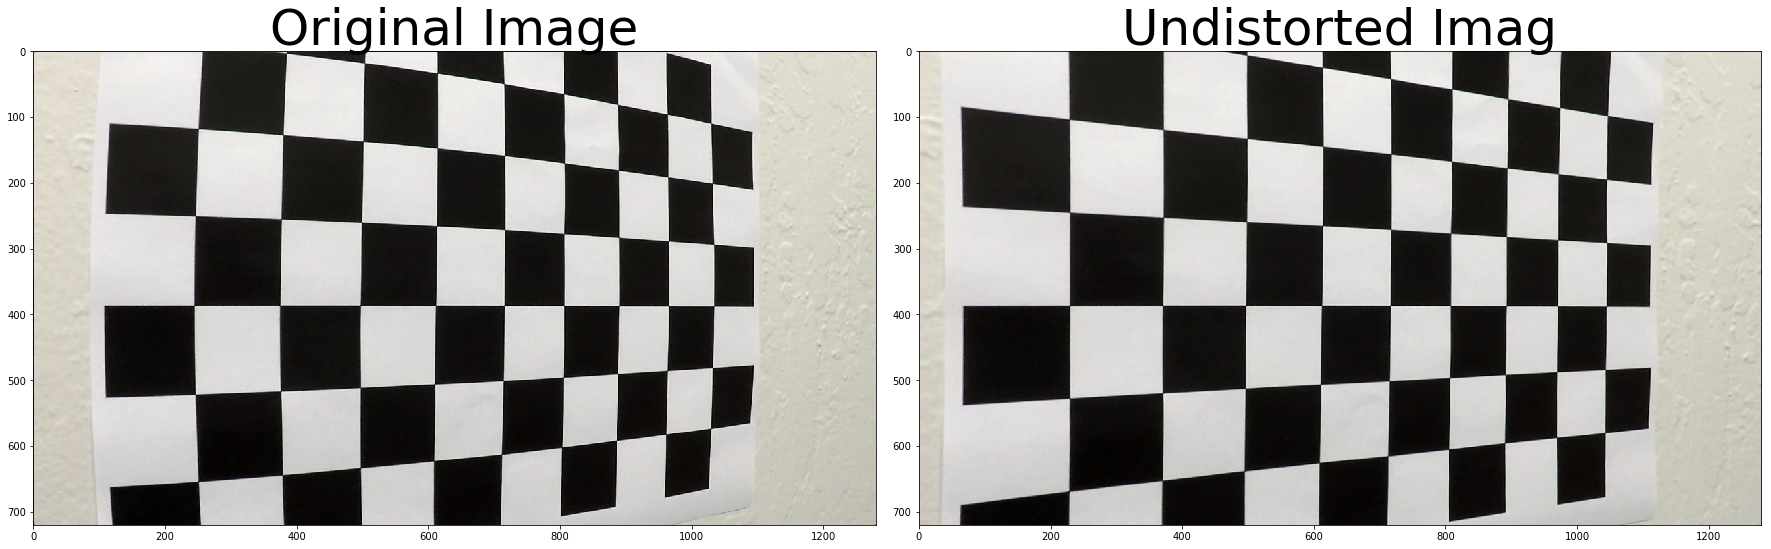

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

undist = cv2.undistort(img, mtx, dist, None, mtx)

# convert to RGB color space for display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist= cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Imag', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


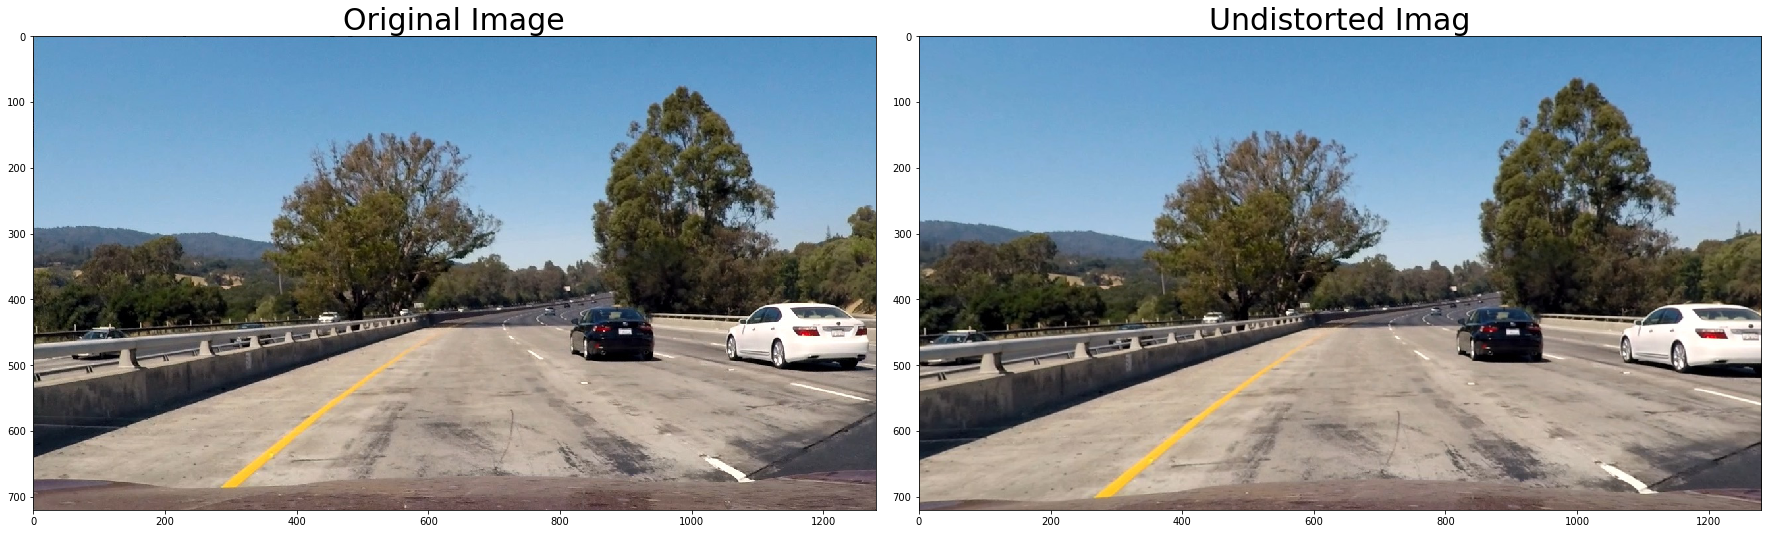

In [4]:
img = cv2.imread('./test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

undist = cv2.undistort(img, mtx, dist, None, mtx)

# convert to RGB color space for display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Imag', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Step 3 Use color transforms, gradients, etc., to create a thresholded binary image.

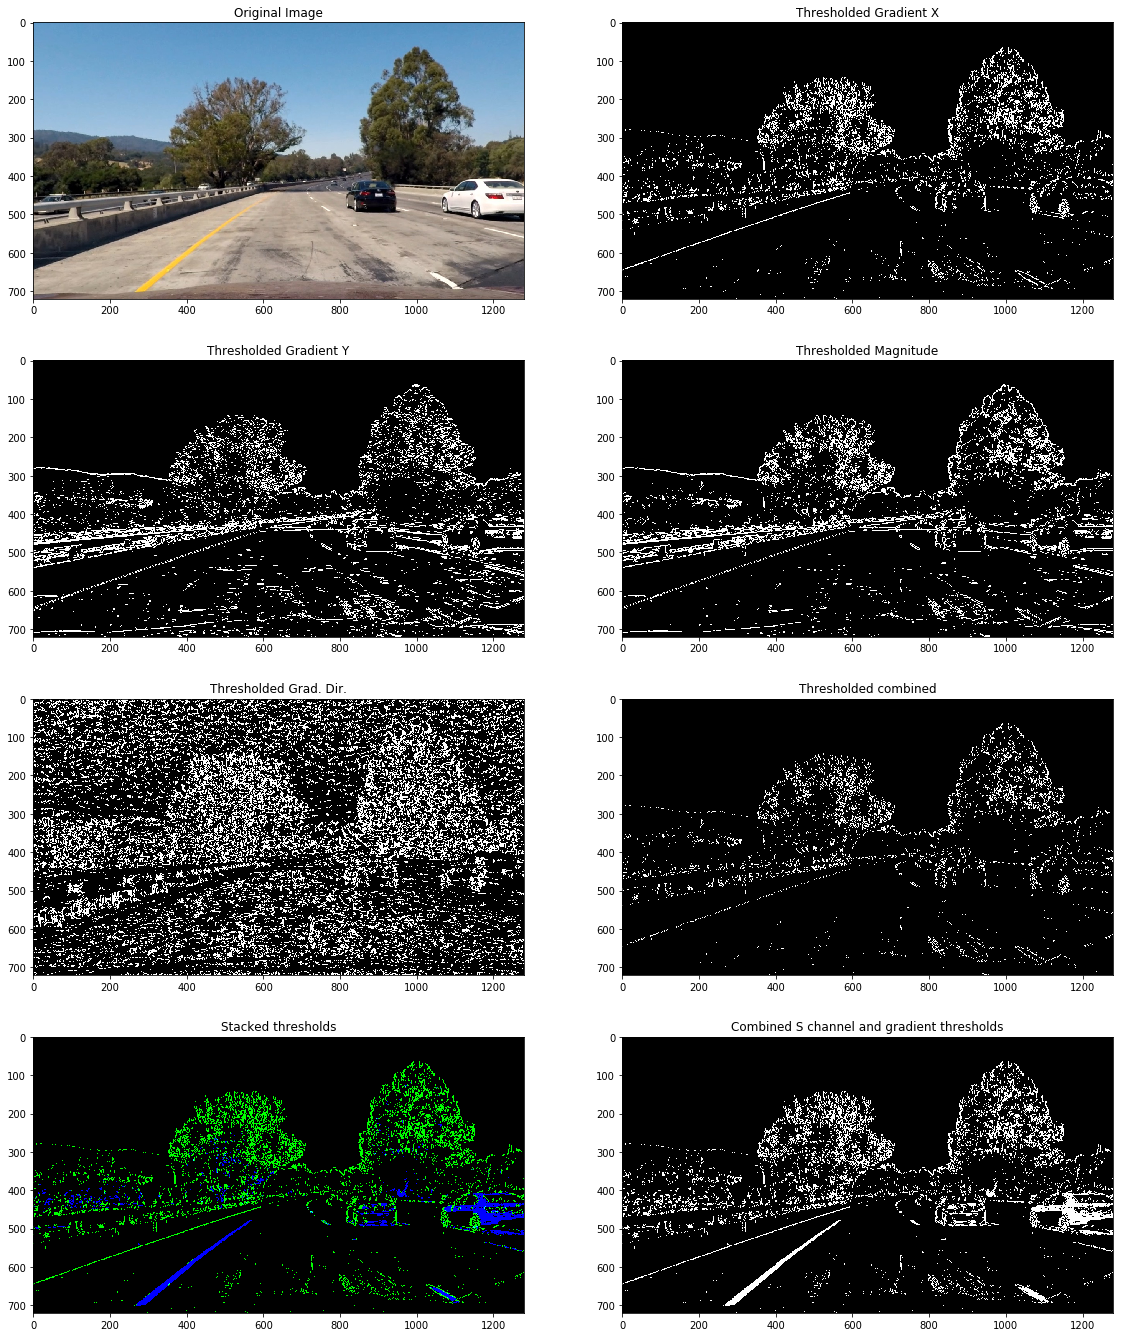

In [5]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)): 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Calculate gradient direction
    # Apply threshold
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

# Choose a Sobel kernel size
ksize = 3  # Choose a larger odd number to smooth gradient measurements

# Read in an image
image = undist

# Run the gradient x operation
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20, 100))

# Run the gradient y operation
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh=(20, 100))

# Run the Magnitude function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

# Run the gradient direction function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.1, 0.7))

combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:, :, 2]

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((np.zeros_like(grad_binary_x), grad_binary_x, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(grad_binary_x)
combined_binary[(s_binary == 1) | (grad_binary_x == 1)] = 1

# Plot the result
f, ax = plt.subplots(4, 2, figsize=(15, 20))
ax[0, 0].imshow(image)
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(grad_binary_x, cmap='gray')
ax[0, 1].set_title('Thresholded Gradient X')
ax[1, 0].imshow(grad_binary_y, cmap='gray')
ax[1, 0].set_title('Thresholded Gradient Y')
ax[1, 1].imshow(mag_binary, cmap='gray')
ax[1, 1].set_title('Thresholded Magnitude')
ax[2, 0].imshow(dir_binary, cmap='gray')
ax[2, 0].set_title('Thresholded Grad. Dir.')
ax[2, 1].imshow(combined, cmap='gray')
ax[2, 1].set_title('Thresholded combined')
ax[3, 0].imshow(color_binary)
ax[3, 0].set_title('Stacked thresholds')
ax[3, 1].imshow(combined_binary, cmap='gray')
ax[3, 1].set_title('Combined S channel and gradient thresholds')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('processed.png')


## Step 4  Apply a perspective transform to rectify binary image ("birds-eye view").

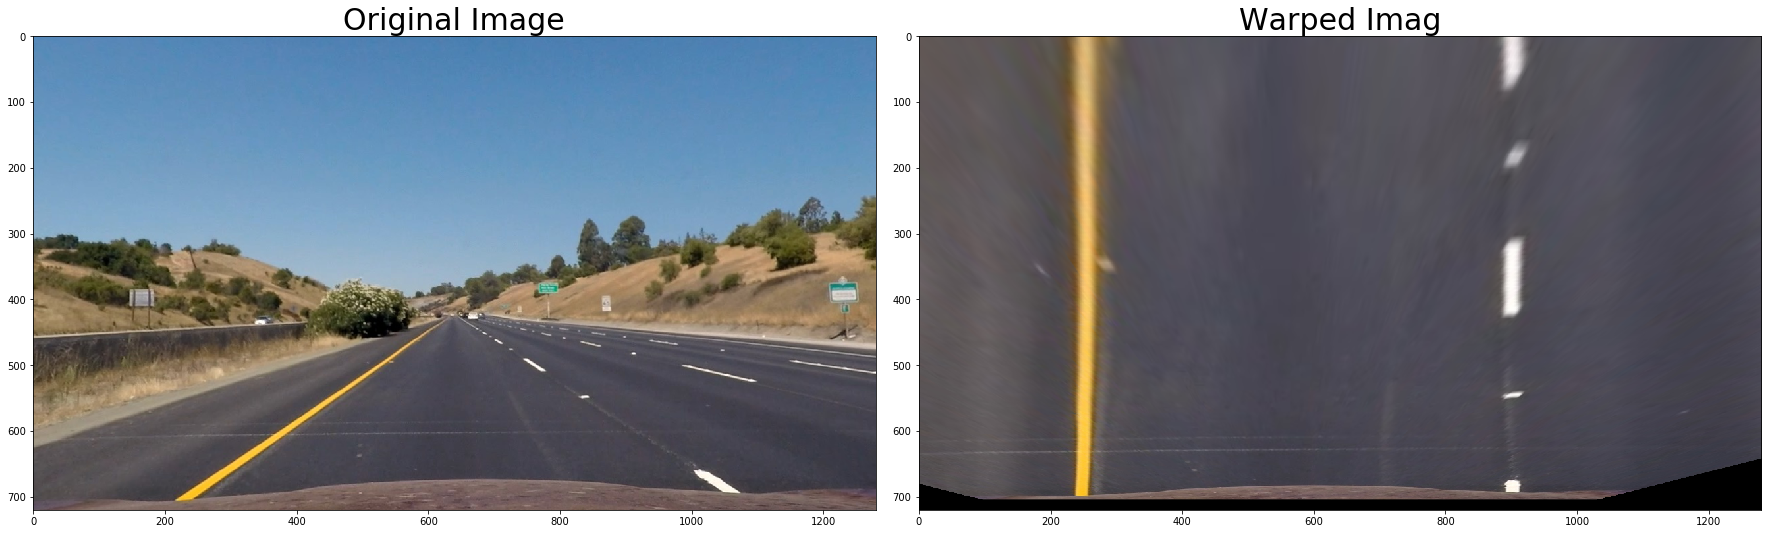

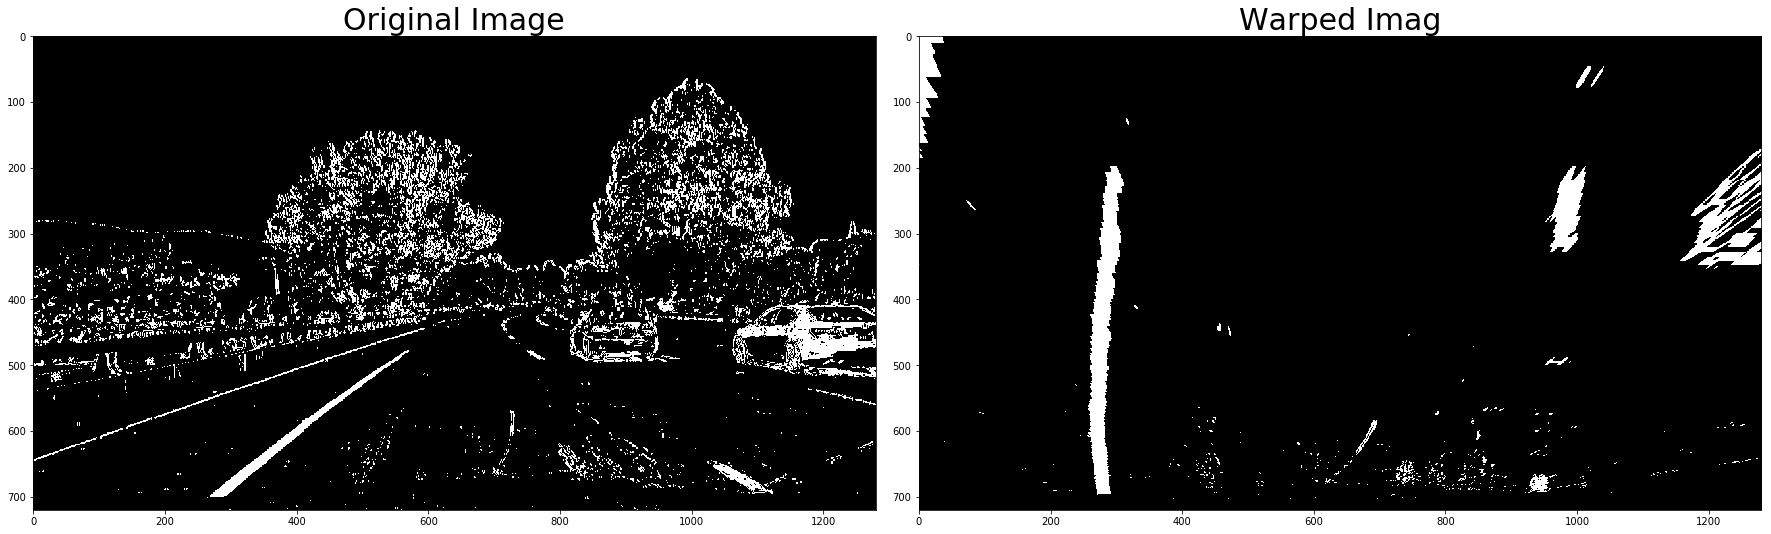

In [6]:

img = cv2.imread('./test_images/straight_lines1.jpg')
undist_s = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./test_images/straight_lines1_undist.jpg', undist)

img_size = (undist.shape[1], undist.shape[0])
undist_s = cv2.cvtColor(undist_s, cv2.COLOR_BGR2RGB)

# Use a trapezoid to do perspective transform of a straight line image
src = np.float32([[577, 463], [250, 692], [705, 463], [1059, 692]])
dst = np.float32([[250, 0], [250, 692], [900, 0], [900, 692]])

M = cv2.getPerspectiveTransform(src, dst)
warped_s = cv2.warpPerspective(undist_s, M, img_size, flags=cv2.INTER_LINEAR)

# Perspective transform of a curve image
warped_c = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_s)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_s, cmap='gray')
ax2.set_title('Warped Imag', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_c, cmap='gray')
ax2.set_title('Warped Imag', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Step 5 Detect lane pixels and fit to find the lane boundary.

(720, 0)

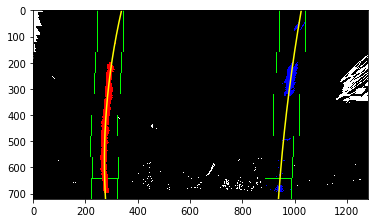

In [7]:

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Find polynomial from ground
def FindPolynomial(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0) 
    # plt.plot(histogram)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = search_window_n
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = search_window_margin
    # Set minimum number of pixels found to recenter window
    minpix = search_recenter_pixels
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 
        
        # Debug code
        # plt.imshow(out_img)
        # plt.savefig('out_img' + str(window) + '.png')

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    # debug code
    # binary_warped = warped_c
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # calculate car offset from center
    lane_midpoint = (left_fitx[-1] + right_fitx[-1]) / 2
    road_center = binary_warped.shape[1] / 2
    car_offset = (road_center - lane_midpoint) * xm_per_pix    

    return left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset

left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset = FindPolynomial(warped_c)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
    

In [8]:

# Find polynomial based on previous frame
def FindNextPolynomial(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = search_window_margin
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + 
    left_fit[1] * nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + 
    right_fit[1] * nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # calculate car offset from center
    lane_midpoint = (left_fitx[-1] + right_fitx[-1]) / 2
    road_center = binary_warped.shape[1] / 2
    car_offset = (road_center - lane_midpoint) * xm_per_pix

    return left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, result, car_offset


## Step 6 Determine the curvature of the lane and vehicle position with respect to center.

In [9]:

def MeasureCurvature(left_fit, right_fit, leftx, lefty, rightx, righty, ploty):
   
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

    return left_curverad, right_curverad
    
left_curverad, right_curverad = MeasureCurvature(left_fit, right_fit, leftx, lefty, rightx, righty, ploty)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


828.972745569 m 2290.25347015 m


## Step 7 Warp the detected lane boundaries back onto the original image.

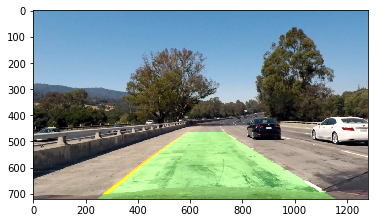

In [10]:

def WarpBack(original_image, warped_c, M, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_c).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M)

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

result = WarpBack(undist, warped_c, M, left_fitx, right_fitx, ploty)
    
plt.imshow(result)


## Step 8 Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [11]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float') 
        
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # frame time in video
        self.time = 0
        
        self.ploty = None

def process_image(image):   
    # step 1 Apply a distortion correction
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # step 2 Use color transforms, gradients, etc., to create a thresholded binary image    
    grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20, 100))

    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(grad_binary_x), grad_binary_x, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_binary_x)
    combined_binary[(s_binary == 1) | (grad_binary_x == 1)] = 1   
  
    # step 3 Apply a perspective transform to rectify binary image
    warped_c = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # step 4 Detect lane pixels and fit to find the lane boundary
    if line_l.detected == True and line_r.detected == True:
        left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset = \
            FindNextPolynomial(warped_c, line_l.current_fit, line_r.current_fit)
    else:
        left_fit, right_fit, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, out_img, car_offset = \
            FindPolynomial(warped_c)

    # step 5 Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad = MeasureCurvature(left_fit, right_fit, leftx, lefty, rightx, righty, ploty)      
    
    # step 5.1 record info of each frame before modification
    if (debug == True):
        if (csv_writer_o != None):
            csv_writer_o.writerow(['{:4.2f}'.format(line_l.time)] \
                               + [left_curverad - right_curverad] + [left_fit[0] - right_fit[0]] + [left_fit[0] / right_fit[0]] \
                               + [car_offset] + [left_curverad] + [right_curverad] \
                               + [left_fit[0]] + [right_fit[0]] + [left_fit[1]] + [right_fit[1]] + [left_fit[2]] + [right_fit[2]] \
                               + [left_fit[1] - right_fit[1]] + [left_fit[2] - right_fit[2]] \
                               + [left_fit[1] / right_fit[1]] + [left_fit[2] / right_fit[2]])

    # step 5.2 Sanity check
    # if curvzture changes too much, skip it
    # if left and right fit is not parallel, skip it
    if (line_l.detected == True and line_r.detected == True) and \
        (abs(left_curverad - right_curverad) > curvature_margin \
        or abs(left_fit[0] - right_fit[0]) > parallel_margin): 
            left_curverad = line_l.radius_of_curvature
            right_curverad = line_r.radius_of_curvature
            left_fit = line_l.current_fit
            right_fit = line_r.current_fit
            left_fitx = line_l.allx
            right_fitx = line_r.allx
            ploty = line_l.ploty

    if (debug == True):
        if (csv_writer_m != None):
            csv_writer_m.writerow(['{:4.2f}'.format(line_l.time)] \
                               + [left_curverad - right_curverad] + [left_fit[0] - right_fit[0]] + [left_fit[0] / right_fit[0]] 
                               + [car_offset] + [left_curverad] + [right_curverad] \
                               + [left_fit[0]] + [right_fit[0]] + [left_fit[1]] + [right_fit[1]] + [left_fit[2]] + [right_fit[2]] \
                               + [left_fit[1] - right_fit[1]] + [left_fit[2] - right_fit[2]] \
                               + [left_fit[1] / right_fit[1]] + [left_fit[2] / right_fit[2]])
    line_l.time = line_l.time + slice_of_time
        
    # step 5.3 smooth by the average of last n frames' x 
    if line_l.detected == True and line_r.detected == True:
        if (len(line_l.recent_xfitted) < keep_last_n):
            line_l.recent_xfitted.append(left_fitx)
        else:
            line_l.recent_xfitted.pop(0)
            line_l.recent_xfitted.append(left_fitx)

        if (len(line_r.recent_xfitted) < keep_last_n):
            line_r.recent_xfitted.append(right_fitx)
        else:
            line_r.recent_xfitted.pop(0)
            line_r.recent_xfitted.append(right_fitx)

        left_fitx = line_l.recent_xfitted[0]
        right_fitx = line_r.recent_xfitted[0]
        if (len(line_l.recent_xfitted) == (keep_last_n)):       
            for i in range(keep_last_n - 1):
                left_fitx = left_fitx + line_l.recent_xfitted[i + 1]
                right_fitx = right_fitx + line_r.recent_xfitted[i + 1]
            left_fitx = left_fitx / keep_last_n
            right_fitx = right_fitx / keep_last_n

    # step 6 Warp the detected lane boundaries back onto the original image
    result = WarpBack(undist, warped_c, M, left_fitx, right_fitx, ploty)
    
    # step 7 record line info
    line_l.detected = True
    line_r.detected = True
    line_l.current_fit = left_fit
    line_r.current_fit = right_fit
    line_l.radius_of_curvature = left_curverad
    line_r.radius_of_curvature = right_curverad
    line_l.allx = left_fitx
    line_r.allx = right_fitx
    line_l.ploty = ploty
    line_r.ploty = ploty
    
    # step 8 annotation
    font = cv2.FONT_HERSHEY_DUPLEX 

    text = "Radius of Crvature of the Lane: {:.0f} m".format((left_curverad + right_curverad) / 2)
    cv2.putText(result, text, (30, 30), font, 1, (255, 255, 255), 2)
    
    if car_offset > 0:
        text = "Vehicle Position: Offset Right from Center with {:.2f} m".format(car_offset)
    else:
        text = "Vehicle Position: Offset Left from Center with {:.2f} m".format(abs(car_offset))
    cv2.putText(result, text, (30, 60), font, 1, (255, 255, 255), 2)

    # cv2.putText(result, 'Left Fit '+str(left_fit), (30,90), font, 1, (255,255,255), 2)
    # cv2.putText(result, 'Right Fit '+str(right_fit), (30,120), font, 1, (255,255,255), 2)  
       
    return result


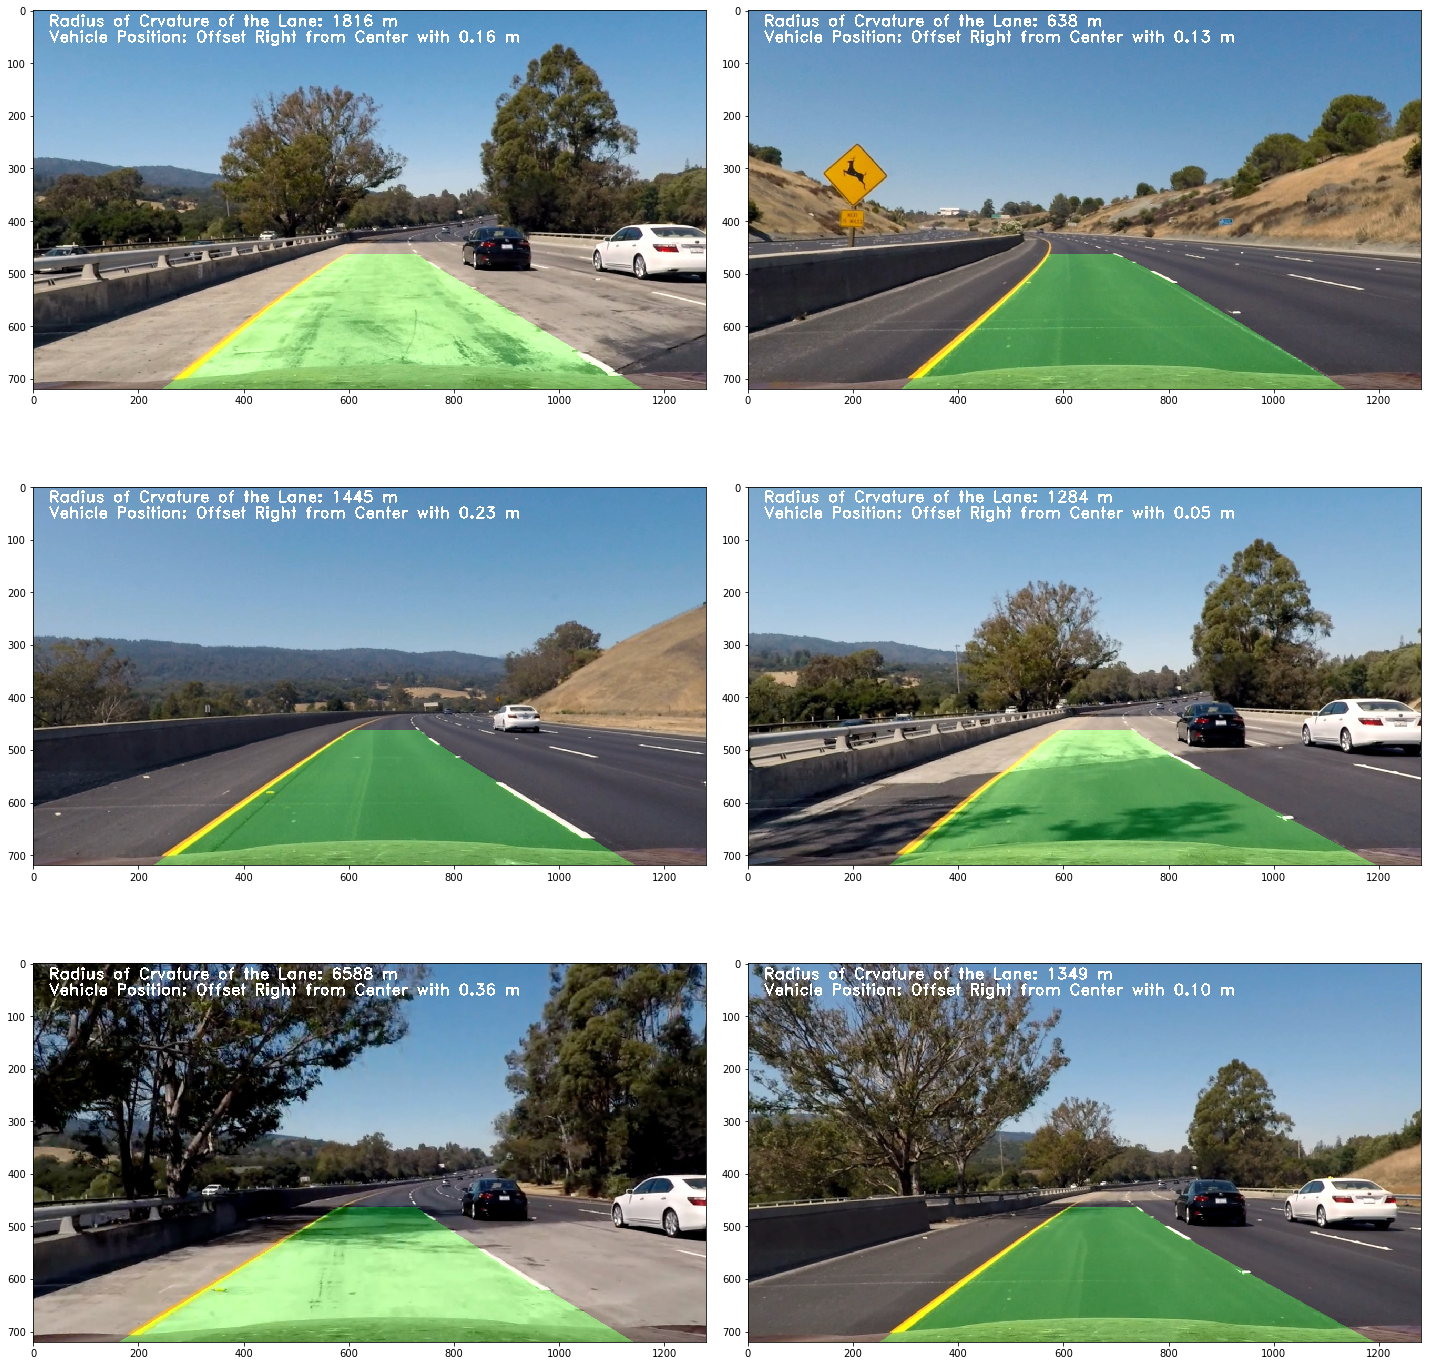

In [12]:

# verify test images
test_images = np.empty(6, dtype=object)
test_images[0] = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB) 
test_images[1] = cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB) 
test_images[2] = cv2.cvtColor(cv2.imread('./test_images/test3.jpg'), cv2.COLOR_BGR2RGB) 
test_images[3] = cv2.cvtColor(cv2.imread('./test_images/test4.jpg'), cv2.COLOR_BGR2RGB) 
test_images[4] = cv2.cvtColor(cv2.imread('./test_images/test5.jpg'), cv2.COLOR_BGR2RGB) 
test_images[5] = cv2.cvtColor(cv2.imread('./test_images/test6.jpg'), cv2.COLOR_BGR2RGB) 

result_images = np.empty(6, dtype=object)

for i in range(6):
    line_l = Line()
    line_r = Line()
    result_images[i] = process_image(test_images[i])
  
f, ax = plt.subplots(3, 2, figsize=(20, 20))
f.tight_layout()
ax[0, 0].imshow(result_images[0])
ax[0, 1].imshow(result_images[1])
ax[1, 0].imshow(result_images[2])
ax[1, 1].imshow(result_images[3])
ax[2, 0].imshow(result_images[4])
ax[2, 1].imshow(result_images[5])


In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import csv

# clear line record
line_l = Line()
line_r = Line()

csvfile_o = open('process_image_data_orig.csv', 'w')
csv_writer_o = csv.writer(csvfile_o, delimiter=',', lineterminator='\n')

csvfile_m = open('process_image_data_modify.csv', 'w')
csv_writer_m = csv.writer(csvfile_m, delimiter=',', lineterminator='\n')

white_output = './project_video_all.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

csvfile_o.close()
csvfile_m.close()


[MoviePy] >>>> Building video ./project_video_all.mp4
[MoviePy] Writing video ./project_video_all.mp4


100%|██████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:37<00:00,  6.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_all.mp4 

Wall time: 3min 38s
